# Speech Decomposition with Source Filter Model

In this example, we're going to decompose a speech signal into its source $e[n]$ and filter components $a_k$, following the LPC model.  

$$
s[n] = e[n] + \sum_{k=1}^M a_k s[n-k]
$$

We'll first use the traditional method to estimate the LPC filter, and then we'll use our differentiable LPC to do end-to-end decomposition.

In [1]:
import torch
import torch.nn.functional as F
import torchaudio
import math
import numpy as np
from torchaudio.functional import lfilter
import matplotlib.pyplot as plt
from IPython.display import Audio
import diffsptk
from itertools import accumulate
from tqdm import tqdm

We're going to use a speech sample from the [CMU Arctic](http://festvox.org/cmu_arctic/) speech synthesis database. 

In [2]:
!wget "http://festvox.org/cmu_arctic/cmu_arctic/cmu_us_awb_arctic/wav/arctic_a0007.wav"

--2023-10-28 12:15:37--  http://festvox.org/cmu_arctic/cmu_arctic/cmu_us_awb_arctic/wav/arctic_a0007.wav
Resolving festvox.org (festvox.org)... 199.4.150.153
Connecting to festvox.org (festvox.org)|199.4.150.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128044 (125K) [audio/x-wav]
Saving to: ‘arctic_a0007.wav.1’

arctic_a0007.wav.1  100%[===================>] 125.04K   322KB/s    in 0.4s    

2023-10-28 12:15:38 (322 KB/s) - ‘arctic_a0007.wav.1’ saved [128044/128044]



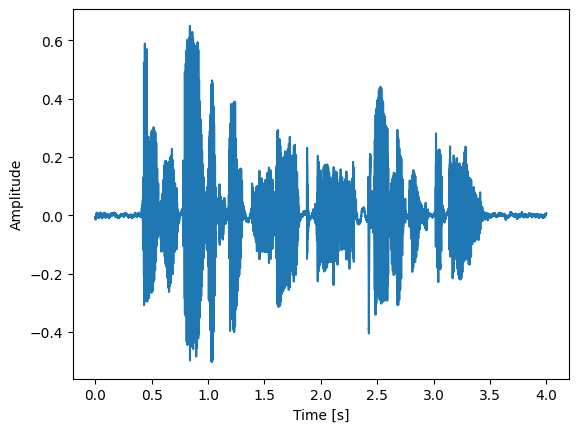

In [2]:
y, sr = torchaudio.load('arctic_a0007.wav')
y = y.squeeze()

plt.plot(np.arange(y.shape[0]) / sr, y.numpy())
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

Audio(y.numpy(), rate=sr)

Let's pick up one short segment from the speech, with relatively static pitch and formants for a stationary model.  

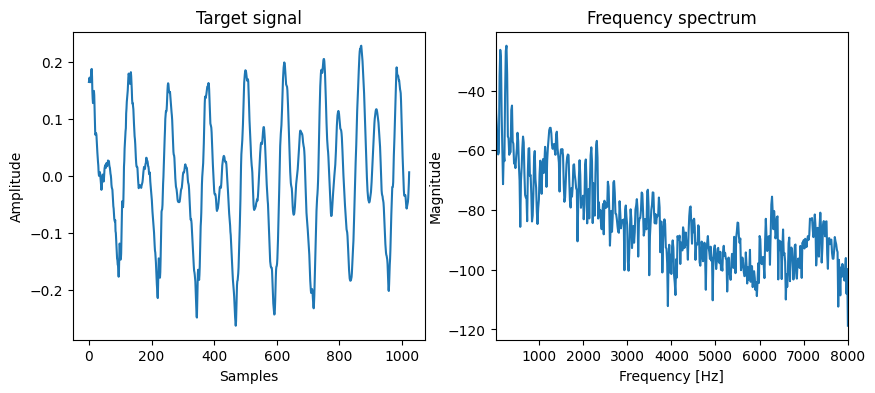

In [40]:
target = y[10000:11024]

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(target.numpy())
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Target signal')
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(target.numpy(), Fs=sr, scale='dB', window=np.hanning(1024))
# plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum') 
plt.xlim(20, 8000)
plt.show()

## Classic LPC Estimation

The common way to estimate the LPC filter is assuming the current sample $s[n]$ can only be approximated from past samples.
This results in minimising the prediction error $e[n]$:

$$
\min_{a_k} \left( s[n] - \sum_{k=1}^M a_k s[n-k] \right)^2 = \min_{a_k} e[n]^2
$$

Its least squares solution can be computed from the autocorrelation of the signal. We'll use the `diffsptk` package to compute this.

In [49]:
lpc_order = 18
frame_length = 1024

lpc = diffsptk.LPC(lpc_order, frame_length)
gain, coeffs = lpc(target).split([1, lpc_order], dim=-1)
print(f'Gain: {gain.item()}')

Gain: 0.2386891394853592


If we plot the spectrum of the LPC filter, we'd see that it approximates the spectral envelope of the signal.

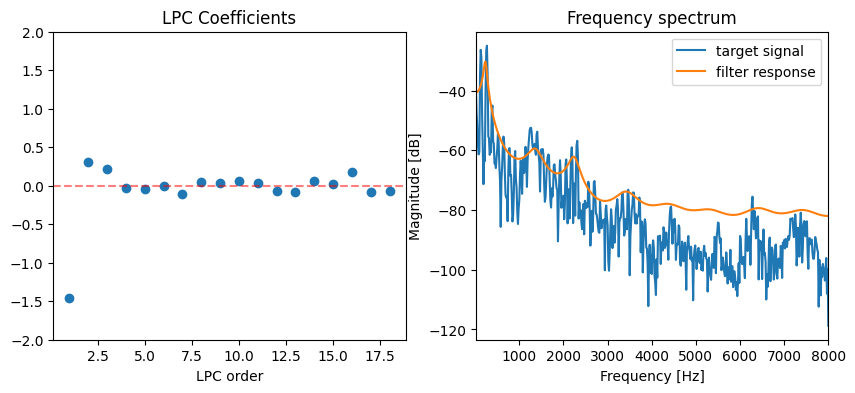

In [54]:
freq_response = gain / torch.fft.rfft(torch.cat([coeffs.new_ones(1), coeffs]), n=frame_length) / frame_length

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.axhline(y = 0, color = 'r', linestyle = 'dashed', alpha = 0.5)
plt.scatter(np.arange(lpc_order) + 1,  coeffs.numpy())
plt.xlabel('LPC order')
plt.title('LPC Coefficients')
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(target.numpy(), Fs=sr, scale='dB', window=np.hanning(1024), label='target signal')
plt.plot(np.arange(frame_length // 2 + 1) / frame_length * sr, 20 * np.log10(np.abs(freq_response.numpy())), label='filter response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Frequency spectrum')
plt.xlim(20, 8000)
plt.legend()
# plt.xscale('log')
plt.show()

We can get the source (or residual) $e[n]$ by inverse filtering the signal with the LPC coefficients, which is equivalent to the filtering the signal with a FIR filter $[1, -a_1, -a_2, \dots, -a_M]$.

$$
e[n] = s[n] - \sum_{k=1}^M a_k s[n-k]
$$

In [55]:
e = target + F.conv1d(F.pad(target[None, None, :-1], (lpc_order, 0)), coeffs.flip(0)[None, None, :]).squeeze()
e = e / gain

After cancelling the spectral envelope, the frequency response of the residual becomes flatter and has very equal energy across the spectrum. This is a result of the least squares optimisation, which assumes that the prediction error is white noise.

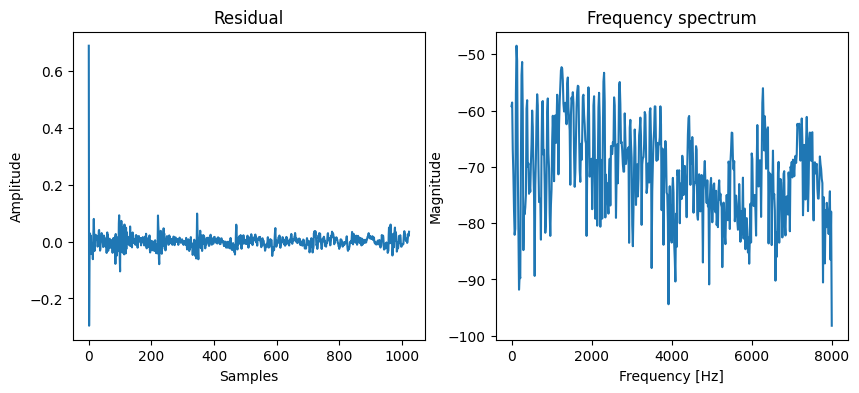

In [57]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(e.numpy())
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Residual')
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(e.numpy(), Fs=sr, scale='dB', window=np.hanning(1024))
# plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum')
plt.show()

## Decomposing Speech with Differentiable LPC and a Glottal Flow Model

In the above example, we have very little assumptions about the source $e[n]$. We only assume that it is whilte-noise like.
In the next example, we're going to incorporate a glottal flow model to give more constraints to the source.

The model we're going to use is the [transformed-LF](https://www.researchgate.net/publication/256309456_The_LF-model_revisited_Transformations_and_frequency_domain_analysis) model, which models the periodic vibration of the vocal folds. This model has only one parameter $R_d$, which is strongly correlated with the perceived vocal effort. 
Although the model is differentiable, for computational efficiency, we're going to use a pre-computed lookup table to approximate the model.

In [76]:
def transformed_lf(Rd: torch.Tensor, points: int = 1024):
    # the implementation is adapted from https://github.com/dsuedholt/vocal-tract-grad/blob/main/glottis.py
    Rd = torch.as_tensor(Rd).view(-1, 1)
    Ra = -0.01 + 0.048 * Rd
    Rk = 0.224 + 0.118 * Rd
    Rg = (Rk / 4) * (0.5 + 1.2 * Rk) / (0.11 * Rd - Ra * (0.5 + 1.2 * Rk))

    Ta = Ra
    Tp = 1 / (2 * Rg)
    Te = Tp + Tp * Rk

    epsilon = 1 / Ta
    shift = torch.exp(-epsilon * (1 - Te))
    delta = 1 - shift

    rhs_integral = (1 / epsilon) * (shift - 1) + (1 - Te) * shift
    rhs_integral /= delta

    lower_integral = -(Te - Tp) / 2 + rhs_integral
    upper_integral = -lower_integral

    omega = torch.pi / Tp
    s = torch.sin(omega * Te)
    y = -torch.pi * s * upper_integral / (Tp * 2)
    z = torch.log(y)
    alpha = z / (Tp / 2 - Te)
    EO = -1 / (s * torch.exp(alpha * Te))

    t = torch.linspace(0, 1, points + 1)[None, :-1]
    before = EO * torch.exp(alpha * t) * torch.sin(omega * t)
    after = (
        (-torch.exp(-epsilon * (t - Te)) + shift) / delta
    )
    return torch.where(t < Te, before, after).squeeze()

Specifically, we're using the derivative of the glottal flow model, which combines the glottal flow with lips radiation by assuming lips radiation is a first-order differentiator.

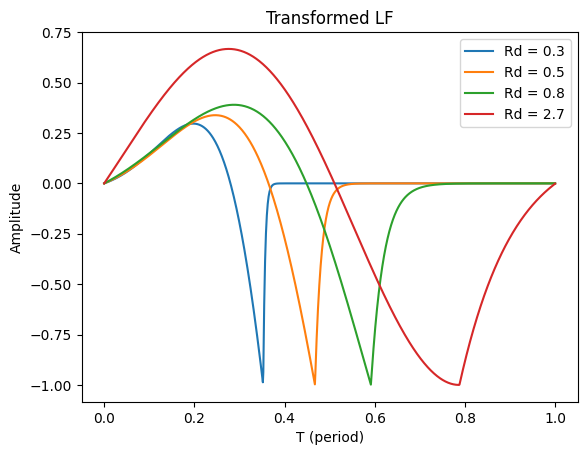

In [75]:
t = torch.linspace(0, 1, 1024)
plt.plot(t, transformed_lf(0.3).numpy(), label='Rd = 0.3')
plt.plot(t, transformed_lf(0.5).numpy(), label='Rd = 0.5')
plt.plot(t, transformed_lf(0.8).numpy(), label='Rd = 0.8')
plt.plot(t, transformed_lf(2.7).numpy(), label='Rd = 2.7')
plt.title('Transformed LF')
plt.legend()
plt.xlabel('T (period)')
plt.ylabel('Amplitude')
plt.show()

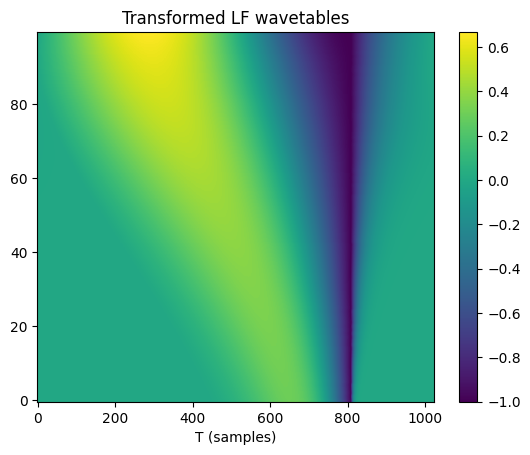

In [93]:
# 0.3 <= Rd <= 2.7 is a reasonable range for Rd
# we sampled them logarithmically for better resolution at lower values
table = transformed_lf(torch.exp(torch.linspace(math.log(0.3), math.log(2.7), 100)))

# align the peaks of the transformed LF for better optimisation
peaks = table.argmin(dim=-1)
shifts = peaks.max() - peaks
aligned_table = torch.stack([torch.roll(table[i], shifts[i].item(), 0) for i in range(table.shape[0])])

plt.title('Transformed LF wavetables')
plt.imshow(aligned_table, aspect='auto', origin='lower')
plt.xlabel('T (samples)')
plt.colorbar()
plt.show()

The full model we're going to use is:

$$
s[n] = g * w\left((\frac{n f_0}{sr} + \phi)  \mod 1; R_d \right) + \sum_{k=1}^M a_k s[n-k].
$$

We replace source $e[n]$ with the following parameters: gain $g$, fundamental frequency $f_0$, phase offset $\phi$, and $R_d$.
$w$ is the pre-computed glottal flow model, and $sr$ is the sampling rate.
Let's define this model in code.

In [205]:
class SourceFilter(torch.nn.Module):
    def __init__(
        self,
        lpc_order: int,
        sr: int,
        table_points=1024,
        num_tables=100,
        init_f0: float = 100.0,
        init_offset: float = 0.0,
        init_gain: float = 0.0,
    ):
        super().__init__()

        Rd_sampled = torch.exp(torch.linspace(math.log(0.3), math.log(2.7), 100))
        table = transformed_lf(Rd_sampled)
        peaks = table.argmin(dim=-1)
        shifts = peaks.max() - peaks
        aligned_table = torch.stack(
            [torch.roll(table[i], shifts[i].item(), 0) for i in range(table.shape[0])]
        )
        self.register_buffer("table", aligned_table)
        self.register_buffer("Rd_sampled", Rd_sampled)

        self.f0 = torch.nn.Parameter(torch.tensor(init_f0))
        self.offset = torch.nn.Parameter(torch.tensor(init_offset))
        self.Rd_index_logits = torch.nn.Parameter(torch.zeros(1))
        self.log_gain = torch.nn.Parameter(torch.tensor(init_gain))

        # we use the reflection coefficients parameterisation for stable optimisation
        self.log_area_ratios = torch.nn.Parameter(torch.zeros(lpc_order))
        self.logits2lpc = torch.nn.Sequential(
            diffsptk.LogAreaRatioToParcorCoefficients(lpc_order),
            diffsptk.ParcorCoefficientsToLinearPredictiveCoefficients(lpc_order),
        )

        self.lpc_order = lpc_order
        self.table_points = table_points
        self.num_tables = num_tables
        self.sr = sr

    @property
    def Rd_index(self):
        return torch.sigmoid(self.Rd_index_logits) * (self.num_tables - 1)

    @property
    def Rd(self):
        return self.Rd_sampled[torch.round(self.Rd_index).long().item()]

    @property
    def gain(self):
        return torch.exp(self.log_gain)

    @property
    def filter_coeffs(self):
        return self.logits2lpc(torch.cat([self.log_gain.view(1), self.log_area_ratios])).split(
            [1, self.lpc_order]
        )

    def source(self, steps):
        # select the wavetable using linear interpolation
        select_index_floor = self.Rd_index.long().item()
        p = self.Rd_index - select_index_floor
        selected_table = (
            table[select_index_floor] * (1 - p) + table[select_index_floor + 1] * p
        )

        # generate the source signal by interpolating the wavetable
        phase = (
            torch.arange(steps, device=selected_table.device, dtype=selected_table.dtype)
            / self.sr
            * self.f0
            + self.offset
        ) % 1
        phase_index = phase * self.table_points
        # append the first sample to the end for easier interpolation
        padded_table = torch.cat([selected_table, selected_table[:1]])
        phase_index_floor = phase_index.long()
        phase_index_ceil = phase_index_floor + 1
        p = phase_index - phase_index_floor
        glottal_pulse = (
            padded_table[phase_index_floor] * (1 - p)
            + padded_table[phase_index_ceil] * p
        )
        return glottal_pulse
    
    def forward_filt(self, e):
        # get filter coefficients
        log_gain, lpc_coeffs = self.filter_coeffs

        # apply the LPC filter
        b = log_gain.new_zeros(1 + lpc_coeffs.shape[-1])
        b[0] = torch.exp(log_gain)
        a = torch.cat([lpc_coeffs.new_ones(1), lpc_coeffs])
        return lfilter(e, a, b, clamp=False)

    def forward(self, steps):
        return self.forward_filt(self.source(steps))

    def inverse_filt(self, s):
        # get filter coefficients
        _, lpc_coeffs = self.filter_coeffs

        e = s + F.conv1d(F.pad(s[None, None, :-1], (self.lpc_order, 0)), lpc_coeffs.flip(0)[None, None, :]).squeeze()
        e = e / self.gain
        return e

Proper initialisation of the parameters plays an important role in the optimisation. We're going to use the following initialisation.

In [250]:
model = SourceFilter(lpc_order, sr, init_f0=130.0, init_offset=0., init_gain=-1.3)


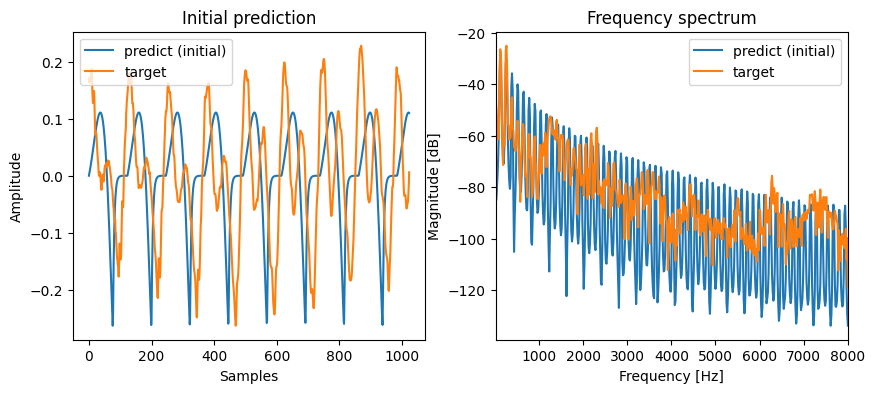

In [252]:
with torch.no_grad():
    output = model(1024)


fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Initial prediction")
plt.plot(output.numpy(), label='predict (initial)')
plt.plot(target.numpy(), label='target')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(output.numpy(), Fs=sr, scale='dB', window=np.hanning(1024), label='predict (initial)')
plt.magnitude_spectrum(target.numpy(), Fs=sr, scale='dB', window=np.hanning(1024), label='target')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Frequency spectrum')
plt.xlim(20, 8000)
plt.legend()
plt.show()

Let's optimise the parameters with gradient descent.
We're going to use the famous Adam optimiser with a learning rate of 0.001 and run it for 2000 iterations.
The loss function we're going to use is the L1 loss between the original signal and the modelled signal.

In [253]:
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001
)

with tqdm(range(2000)) as pbar:
    for _ in pbar:
        optimizer.zero_grad()
        output = model(1024)
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f'loss: {loss.item():.4f}')



loss: 0.0281: 100%|██████████| 2000/2000 [00:08<00:00, 248.43it/s]


Gain: 0.184428870677948
Rd: 1.5502203702926636
f0: 131.02684020996094
Offset: 0.94825154915452


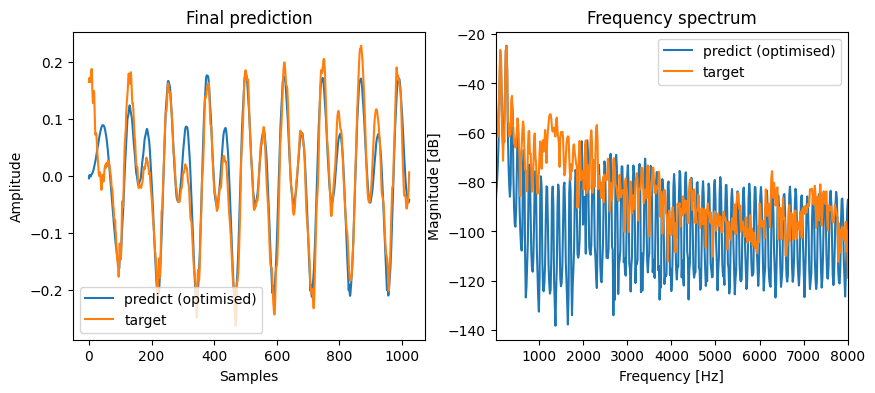

In [254]:
with torch.no_grad():
    final_output = model(1024)

print(f"Gain: {model.gain.item()}")
print(f"Rd: {model.Rd.item()}")
print(f"f0: {model.f0.item()}")
print(f"Offset: {model.offset.item() % 1}")

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Final prediction")
plt.plot(final_output.numpy(), label='predict (optimised)')
plt.plot(target.numpy(), label='target')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(final_output.numpy(), Fs=sr, scale='dB', window=np.hanning(1024), label='predict (optimised)')
plt.magnitude_spectrum(target.numpy(), Fs=sr, scale='dB', window=np.hanning(1024), label='target')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Frequency spectrum')
plt.xlim(20, 8000)
plt.legend()
plt.show()

Wow, this is pretty good! We can see that the model reconstructs the original signal quite well with very similar waveforms.
Moreover, the model tells what are the optimal parameters to construct the source signal.
Let's see what is the source signal looks like compared to the residual on the target signal using our estimated parameters.

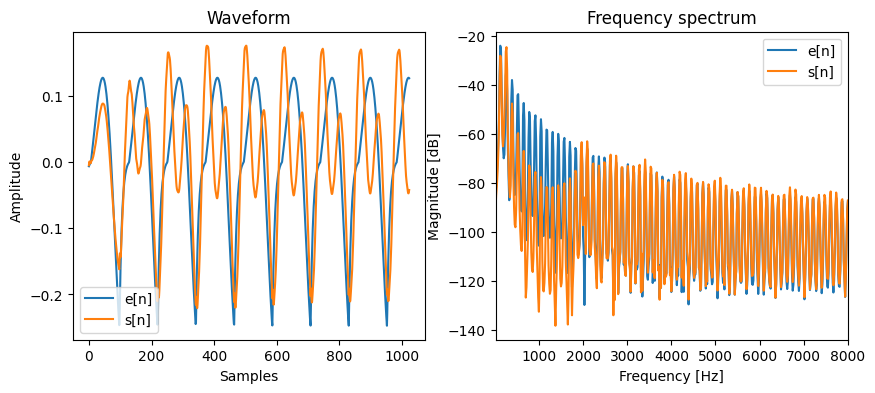

In [255]:
with torch.no_grad():
    e = model.source(1024)
    s = model.forward_filt(e)
    e_inv = model.inverse_filt(target)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title('Waveform')
ax[0].plot(e.numpy() / 4, label='e[n]')
ax[1].set_title('Frequency spectrum')
ax[1].magnitude_spectrum(e.numpy() / 4, Fs=sr, scale='dB', window=np.hanning(1024), label='e[n]')
# ax[1, 0].set_title('Filtered source signal')
ax[0].plot(s.numpy(), label='s[n]')
ax[1].magnitude_spectrum(s.numpy(), Fs=sr, scale='dB', window=np.hanning(1024), label='s[n]')
ax[0].set_xlabel('Samples')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Magnitude [dB]')
ax[1].set_xlim(20, 8000)
ax[0].legend()
ax[1].legend()
plt.show()

Let's compare the spectrum of the two filters.

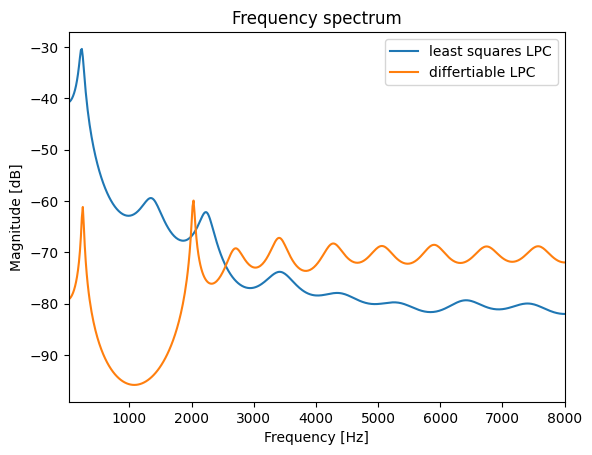

In [236]:
_, lpc_coeffs = model.filter_coeffs
with torch.no_grad():
    freq_response_opt = model.gain / torch.fft.rfft(torch.cat([lpc_coeffs.new_ones(1), lpc_coeffs]), n=frame_length) / frame_length

plt.plot(np.arange(frame_length // 2 + 1) / frame_length * sr, 20 * np.log10(np.abs(freq_response.numpy())), label='least squares LPC')
plt.plot(np.arange(frame_length // 2 + 1) / frame_length * sr, 20 * np.log10(np.abs(freq_response_opt.numpy())), label='differtiable LPC')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Frequency spectrum')
plt.xlim(20, 8000)
plt.legend()
plt.show()